In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy
from dataset import Dataset

# Constants

In [168]:
DATASET_PATH = 'dataset/bag/'
NUM_BIN = 8

In [169]:
data = Dataset(DATASET_PATH)

# Kernel

In [170]:
BAND = 255 /NUM_BIN
def to_b_num(img):
    b = (img //BAND).astype(int)
    return numpy.minimum(b, 7)

In [171]:
def create_kernel(r, c):
    """
    create kernel with epancechnikov profile
    
    @param r, c: size
    """
    rr = numpy.arange(r) / (r-1) *2 -1
    cc = numpy.arange(c) / (c-1) *2 -1
    C, R = numpy.meshgrid(cc, rr)
    X2 = C**2 + R**2
    
    kernel = numpy.maximum(1-X2, 0)
    return kernel / numpy.sum(kernel)

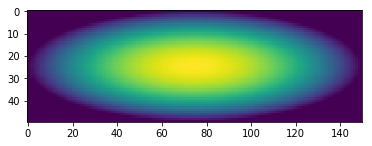

In [173]:
plt.imshow(create_kernel(50, 150))

# Target model

In [175]:
def create_target_model(target_img):
    B = to_b_num(target_img)
    
    kernel = create_kernel(*target_img.shape[:2])
    
    M = numpy.empty((NUM_BIN, 3))
    for b in range(NUM_BIN):
        for ch in range(3):
            M[b, ch] = numpy.sum(kernel[B[:,:,ch]==b])
            
    return M

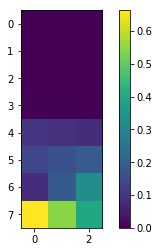

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.00499092  0.00396631  0.00072165]
 [ 0.10339642  0.09344824  0.08623304]
 [ 0.14151272  0.16760138  0.18993672]
 [ 0.08680921  0.1887085   0.32822262]
 [ 0.66329073  0.54627557  0.39488597]]


In [191]:
tm = create_target_model(data.target(0))

plt.imshow(tm)
plt.colorbar()
plt.show()
print(tm)

# Target Candidate

In [193]:
def create_target_candidate(img, center, diameter):
    """
    @param orig_img  the entire img
    @param num_bin   the num of hist bins
    @param center    center (x, y)
    @param diameter  mask diameter, aka normalized factor
    """
    R, C = img.shape[:2]
    c, r = center.astype(int)
    
    radius = int(min(diameter/2, R-r, C-c))
    
    target_img = img[r-radius:r+radius, c-radius:c+radius]
    return create_target_model(target_img)

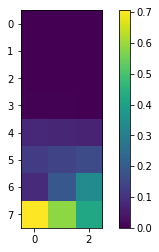

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.37388451e-03   3.58228332e-03   4.88615809e-04]
 [  7.96480430e-02   7.47189361e-02   7.10084460e-02]
 [  1.24682263e-01   1.45002993e-01   1.63884188e-01]
 [  8.58609641e-02   1.91591578e-01   3.40431538e-01]
 [  7.05434845e-01   5.85104210e-01   4.24187212e-01]]


In [195]:
tc = create_target_candidate(data.imgs[0], numpy.array([365, 194]), 132)

plt.imshow(tc)
plt.colorbar()
plt.show()
print(tc)

# Bhattacharyya Coefficient Weight

In [265]:
def calc_weight(img, target_model, target_candidate, center, diameter):
    # pre-calculate weight coef
    C = numpy.zeros((NUM_BIN, 3))
    idx = target_candidate > 0
    C[idx] = numpy.sqrt(target_model[idx] / target_candidate[idx])
    
    ##
#     print('C')
#     plt.imshow(C)
#     plt.colorbar()
#     plt.show()
    
    # estimate range
    diameter = int(diameter)

    cnr_c, cnr_r = center.astype(int) - (diameter >> 1)
    target_img = to_b_num(img[cnr_r:cnr_r+diameter, cnr_c:cnr_c+diameter])
    
    ##
#     print('tracking img')
#     plt.imshow(target_img/7)
#     plt.show()
    
    #
    weight = numpy.empty((diameter, diameter))
    for i in range(diameter):
        for j in range(diameter):
            b_val = target_img[i, j]
            
            c_val = 1.0
            for ch in range(3):
                c_val *= C[b_val[ch], ch]
            weight[i, j] = c_val
    
    ##
#     plt.imshow(weight)
#     plt.colorbar()
#     plt.show()
    return weight

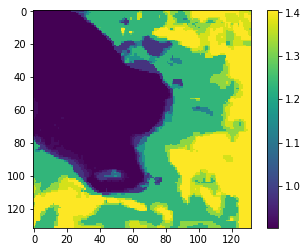

In [268]:
W = calc_weight(data.imgs[1], tm, tc, numpy.array([365, 194]), 132)

plt.imshow(W)
plt.colorbar()
plt.show()

# Meanshift

In [294]:
def meanshift(weight):
    """
    a round of meanshift in the algorithm
    
    @param  weight weight of the target candidates
    @return        translation, in (x, y)
    """
    # create G(X), derivation of kernel k(x)
    r, c = weight.shape
    
    rr = numpy.arange(r) / (r-1) *2 -1
    cc = numpy.arange(c) / (c-1) *2 -1
    
    C, R = numpy.meshgrid(cc, rr)
    G = (C**2 + R**2) < 1
    
    # calculate density
    density = weight *G
    density /= -numpy.sum(density)
    
#     ##
#     plt.imshow(density)
#     plt.colorbar()
#     plt.show()
    
    # measure shift
    C *= density
    R *= density
    
    sft_c = numpy.sum(C) *c
    sft_r = numpy.sum(R) *r
    
    return int(sft_c), int(sft_r)
    

In [293]:
meanshift(W)

(-8, -2)

# Bhattacharyya Coefficient Maximization

Given the target model ${\{\hat{q_u}\}}_{u=1\dots m}$ and its location $\hat{y_0}$ in the previous frame

In [128]:
q = create_target_model(data.target(0))
q

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.00499092,  0.00396631,  0.00072165],
       [ 0.10339642,  0.09344824,  0.08623304],
       [ 0.14151272,  0.16760138,  0.18993672],
       [ 0.08680921,  0.1887085 ,  0.32822262],
       [ 0.66329073,  0.54627557,  0.39488597]])

In [129]:
y0 = numpy.average(data.gtruth[0], 0)
y0

array([ 365.21 ,  194.595])

initialize the location of the target in the current frame with $\hat{y_0}$, compute 
$$
{\{ \hat{p}_u {( \hat{y}_0 )} \}}_{u=1 \dots m}
$$
and evaluate
$$
\rho{[ \hat{p}{( \hat{y}_0 )}, \hat{q} ]}
=
\sum_{u=1}^{m}{\sqrt{
\hat{p}_u( \hat{y}_0 ) \hat{q}_u
}}
$$

In [130]:
h = numpy.min(numpy.diff(data.gtruth[0], axis=0))
h

132.46999999999997

In [131]:
p = create_target_candidate(data.imgs[1], y0, h)
p

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.0162712 ,  0.00518377,  0.00561404],
       [ 0.19463493,  0.2365752 ,  0.26197093],
       [ 0.11124786,  0.09482273,  0.08241354],
       [ 0.67784601,  0.6634183 ,  0.65000148]])

In [132]:
rho = numpy.sum(p * q, 0)
rho

array([ 0.48849202,  0.42043781,  0.33396847])

In [196]:
whos

Variable                  Type        Data/Info
-----------------------------------------------
BAND                      float       31.875
DATASET_PATH              str         dataset/bag/
Dataset                   type        <class '__main__.Dataset'>
NUM_BIN                   int         8
W                         ndarray     132x132: 17424 elems, type `float64`, 139392 bytes (136.125 kb)
WW                        ndarray     132x132: 17424 elems, type `float64`, 139392 bytes (136.125 kb)
calc_weight               function    <function calc_weight at 0x7f81218b99d8>
create_kernel             function    <function create_kernel at 0x7f8121638620>
create_target_candidate   function    <function create_target_c<...>didate at 0x7f81215e6ea0>
create_target_model       function    <function create_target_model at 0x7f812157d048>
cv2                       module      <module 'cv2' from '/opt/<...>36m-x86_64-linux-gnu.so'>
data                      Dataset     <DataSet with 196 imgs>
fi